In [18]:
from pathlib import Path
import os
import shutil
import random
from tqdm import tqdm
import time
from glob import glob
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms, utils
import torchvision.models as models
import torch.nn.functional as F


from google.colab import drive

In [19]:
# drive.mount('/content/drive')

In [20]:
# os.makedirs('/root/.kaggle', exist_ok=True)

# shutil.copy("/content/drive/My Drive/kaggle json/kaggle.json", "/root/.kaggle/kaggle.json")
# 

In [21]:
# !pip install opendatasets

In [22]:
# import opendatasets as od

In [23]:
# od.download("https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c")

In [24]:
root_dir = Path('/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone')

In [25]:
cv = '/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/kidneyData.csv'

In [27]:
df = pd.read_csv(cv)

In [28]:
df.head()

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor


In [29]:
df = df.drop('Unnamed: 0', axis=1)

In [30]:
for dir_path,dir_names, file_names in os.walk(root_dir):
  print(f"There are {len(dir_names)} directories and {len(file_names)} images in {dir_path}")

There are 4 directories and 0 images in /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone
There are 0 directories and 3709 images in /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst
There are 0 directories and 2283 images in /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor
There are 0 directories and 1377 images in /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone
There are 0 directories and 5077 images in /kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal


<Axes: xlabel='Class', ylabel='count'>

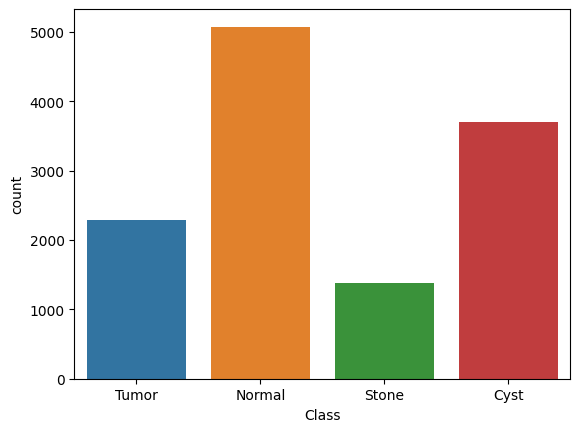

In [31]:
sns.countplot(x=df['Class'])

In [32]:
img_path_list = list(root_dir.glob('*/*'))
len(img_path_list), len(df)


(12446, 12446)

In [33]:

def plot_img(path, img_num,cols):
  img_path_list = list(path.glob('*/*'))
  img_num = min(img_num,len(img_path_list))
  ran_img_list = random.sample(img_path_list,img_num)

  img_name = [name.stem for name in ran_img_list]
  labal = df[df['image_id'].isin(img_name)]['Class'].to_list()

  cols = min(cols,img_num)
  rows = (img_num + cols+1) // cols

  fig,axes = plt.subplots(rows,cols,figsize = (10,10))
  axes = axes.flatten()

  for i in range(img_num):
    img = plt.imread(ran_img_list[i])
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"label: {labal[i]}")

  for j in range(i +1, len(axes)):
    fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

In [69]:
sorted(df.iloc[:, 4].unique())

['Cyst', 'Normal', 'Stone', 'Tumor']

In [35]:
class Kidney(Dataset):
  def __init__(self,root_dir, csv, transform=None):
    self.root_dir = root_dir
    self.csv = pd.read_csv(csv)
    self.transform = transform
    self.img_path_list = list(root_dir.glob('*/*'))
    self.classes = sorted(self.csv.iloc[:, 4].unique())
  def __len__(self):
     return len(self.img_path_list)

  def __getitem__(self,idx):
      img_path = self.root_dir /self.csv.iloc[idx,3] / (self.csv.iloc[idx,1] + '.jpg')
      img = Image.open(img_path).convert("RGB")
      labal = self.csv.iloc[idx,4]

      if self.transform is not None:
        img = self.transform(img)

      return img, labal



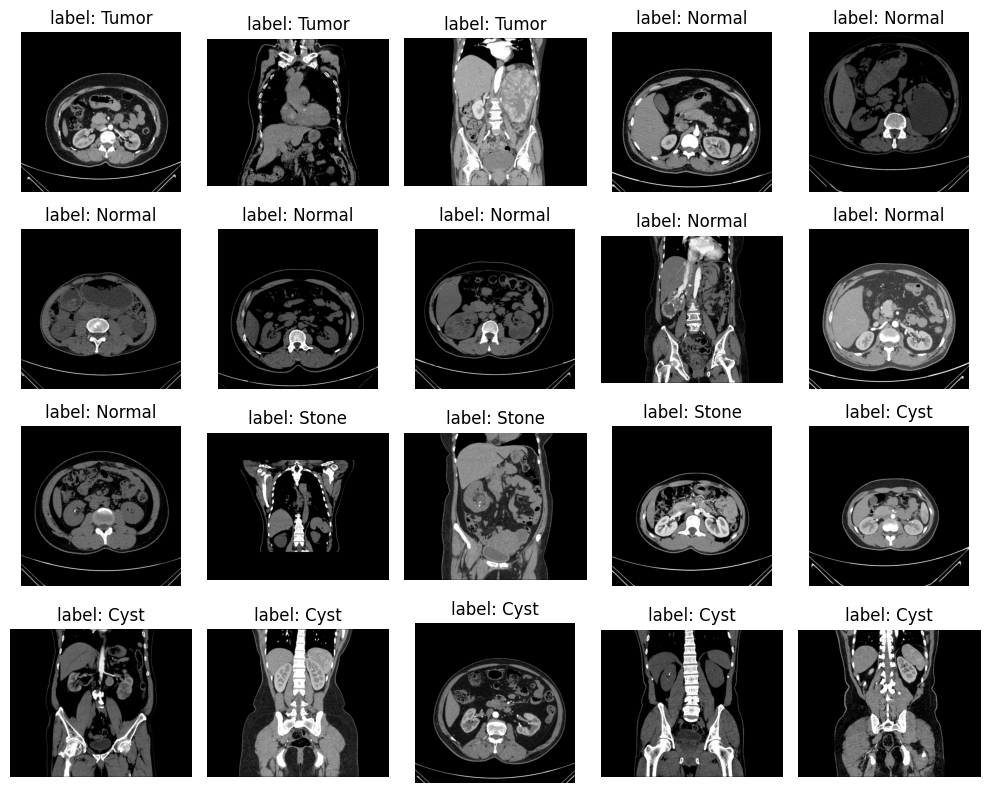

In [34]:
plot_img(root_dir,20,5)

In [36]:
train_transsform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

In [37]:
dataset = Kidney(root_dir,cv,transform=train_transsform)

In [38]:
train, test = torch.utils.data.random_split(dataset,[int(0.8*len(dataset)),len(dataset) - int(0.8*len(dataset))])

In [ ]:
import torchvision.transforms as transforms

# Training Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(15), 
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


In [39]:
train_dataloader = DataLoader(train,batch_size=8,shuffle=True)
test_dataloader = DataLoader(test,batch_size=8,shuffle=False)

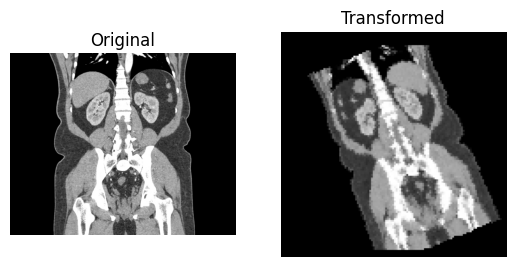

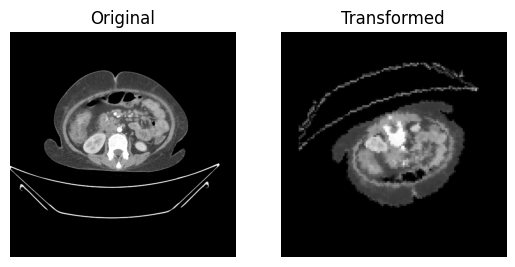

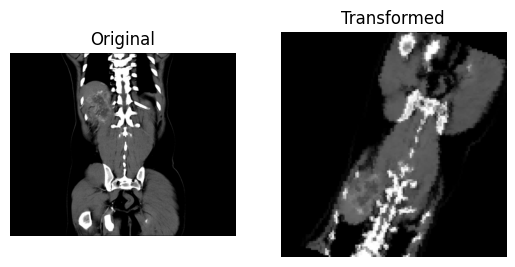

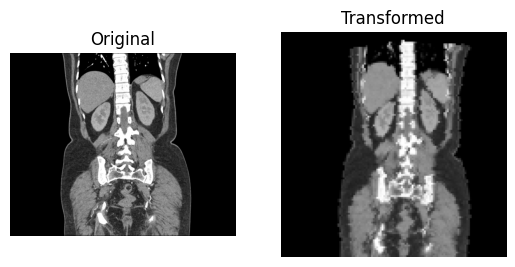

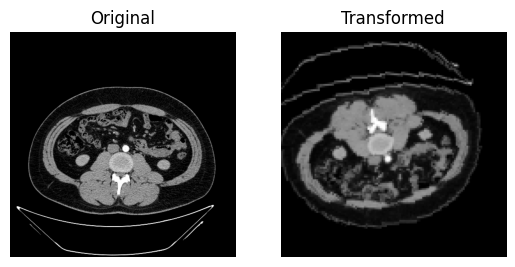

In [41]:
ran_img_list = random.sample(img_path_list,5)
for i in ran_img_list:
  fig,axes = plt.subplots(1,2,)
  img = Image.open(i).convert("RGB")

  axes[0].imshow(img)
  axes[0].axis('off')
  axes[0].set_title("Original")

  trans_img = train_transsform(img)
  trans_img = trans_img.permute(1, 2, 0).numpy()

  axes[1].imshow(trans_img)
  axes[1].axis('off')
  axes[1].set_title("Transformed")

In [45]:

batch_size = 32
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False)

In [47]:
# class_names = dataset.classes
# class_to_idx = dataset.class_to_idx

# print("Classes:", class_names)
# print("len of Classes:", len(class_names))
# print("Class-to-Index Mapping:", class_to_idx)
# print("Train set size:", len(train_dataset))
# print("test set size:", len(test_dataset))

In [49]:
# train_dataset.plot_sample_images(num_images=20)


In [50]:
# train_dataset.plot_transformed_images(num_images=3)

In [53]:
class kidneyEfficientNet(nn.Module):
    def __init__(self, num_classes=44):
        super(kidneyEfficientNet, self).__init__()
        
        self.base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.base_model.classifier = nn.Identity() 
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1) 
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


num_classes = 44
model = kidneyEfficientNet(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adamax(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
criterion = nn.CrossEntropyLoss()

from torchsummary import summary
summary(model, (3, 224, 224))


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 199MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 112, 112]           1,080
       BatchNorm2d-2         [-1, 40, 112, 112]              80
              SiLU-3         [-1, 40, 112, 112]               0
            Conv2d-4         [-1, 40, 112, 112]             360
       BatchNorm2d-5         [-1, 40, 112, 112]              80
              SiLU-6         [-1, 40, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]             960
      BatchNorm2d-14         [-1, 24, 1

In [54]:

def acc_fn(y_pred, y_true):
    return (y_pred == y_true).sum().item() / len(y_true)

In [55]:


def train_step(model, dataloader, loss_fn, acc_fn, optimizer, device):
  size = len(dataloader.dataset)
  batch_size = len(dataloader)
  model.train()
  train_loss, train_acc = 0, 0
  for X, y in dataloader:
    X, y = X.to(device), y.to(device)

    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    acc = acc_fn(y_pred.argmax(dim=1), y)
    train_acc += acc

  return train_acc / batch_size, train_loss / batch_size



In [56]:
def test_step(model, dataloader, loss_fn, acc_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0.0, 0.0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            acc = acc_fn(y_pred.argmax(dim=1), y)
            test_acc += acc

    return test_acc / num_batches, test_loss / num_batches

In [57]:

def trainx(model, train_dataloader, test_dataloader, loss_fn, acc_fn, optimizer, scheduler, device, epochs, save_path="brain_tumor_model.pth"):
    train_acc_list, test_acc_list = [], []
    train_loss_list, test_loss_list = [], []

    for epoch in range(epochs):
        train_acc, train_loss = train_step(model, train_dataloader, loss_fn, acc_fn, optimizer, device)
        test_acc, test_loss = test_step(model, test_dataloader, loss_fn, acc_fn, device)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        test_acc_list.append(test_acc)
        test_loss_list.append(test_loss)

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(test_loss) 
        else:
            scheduler.step() 

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Train Loss: {train_loss:.4f} | Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

        if (epoch + 1) % 4 == 0:
            model_filename = f"{save_path}_epoch{epoch+1}.pth"
            torch.save(model.state_dict(), model_filename)
            print(f"Model saved at epoch {epoch+1}: {model_filename}")

    return train_acc_list, test_acc_list, train_loss_list, test_loss_list


In [58]:
epochs = 20
train_acc_list, test_acc_list, train_loss_list, test_loss_list= trainx(model, train_loader, test_loader, criterion, acc_fn, optimizer, scheduler, device, epochs)

Epoch 1: Train Acc: 0.7975, Train Loss: 0.6188 | Test Acc: 0.9423, Test Loss: 0.1567
Epoch 2: Train Acc: 0.9329, Train Loss: 0.1851 | Test Acc: 0.9768, Test Loss: 0.0656
Epoch 3: Train Acc: 0.9659, Train Loss: 0.0965 | Test Acc: 0.9908, Test Loss: 0.0275
Epoch 4: Train Acc: 0.9763, Train Loss: 0.0685 | Test Acc: 0.9912, Test Loss: 0.0254
Model saved at epoch 4: brain_tumor_model.pth_epoch4.pth
Epoch 5: Train Acc: 0.9808, Train Loss: 0.0564 | Test Acc: 0.9919, Test Loss: 0.0222
Epoch 6: Train Acc: 0.9878, Train Loss: 0.0352 | Test Acc: 0.9964, Test Loss: 0.0080
Epoch 7: Train Acc: 0.9931, Train Loss: 0.0224 | Test Acc: 0.9984, Test Loss: 0.0040
Epoch 8: Train Acc: 0.9938, Train Loss: 0.0194 | Test Acc: 0.9984, Test Loss: 0.0041
Model saved at epoch 8: brain_tumor_model.pth_epoch8.pth


KeyboardInterrupt: 

In [59]:
for param_group in optimizer.param_groups:
    print(f"Learning Rate: {param_group['lr']}")
    print(f"Weight Decay: {param_group.get('weight_decay', 0)}")

Learning Rate: 0.0005
Weight Decay: 0


In [62]:
train_acc_list = [0.7975, 0.9329, 0.9659, 0.9763, 0.9808, 0.9878, 0.9931, 0.9938]
test_acc_list = [0.9423, 0.9768, 0.9908, 0.9912, 0.9919, 0.9964, 0.9984, 0.9984]
train_loss_list = [0.6188, 0.1851, 0.0965, 0.0685, 0.0564, 0.0352, 0.0224, 0.0194]
test_loss_list = [0.1567, 0.0656, 0.0275, 0.0254, 0.0222, 0.0080, 0.0040, 0.0041]


In [63]:

def plot_metrics(train_acc, test_acc, train_loss, test_loss, epochs):
    fig, ax1 = plt.subplots(figsize=(8,5))

    # Left y-axis (Accuracy)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='tab:blue')
    ax1.plot(range(1, epochs+1), train_acc, 'o-', label="Train Accuracy", color='tab:blue')
    ax1.plot(range(1, epochs+1), test_acc, 's-', label="Test Accuracy", color='tab:cyan')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()  
    ax2.set_ylabel('Loss', color='tab:red')
    ax2.plot(range(1, epochs+1), train_loss, 'o--', label="Train Loss", color='tab:red')
    ax2.plot(range(1, epochs+1), test_loss, 's--', label="Test Loss", color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.suptitle('Training & Testing Accuracy and Loss')
    fig.legend(loc="upper center", bbox_to_anchor=(0.7, 0.55), ncol=2)

    plt.show()

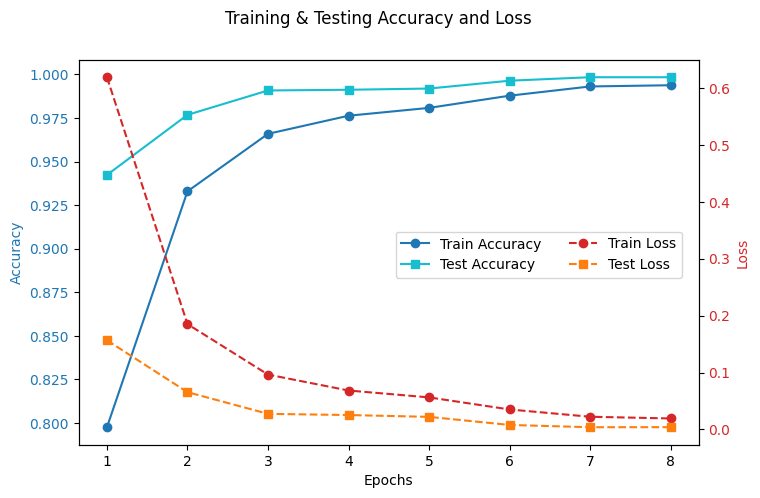

In [65]:
plot_metrics(train_acc_list, test_acc_list, train_loss_list, test_loss_list, epochs = 8)

In [67]:

class kidneyEfficientNet(nn.Module):
    def __init__(self, num_classes=44):
        super(kidneyEfficientNet, self).__init__()
        
        self.base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.base_model.classifier = nn.Identity() 
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1) 
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = kidneyEfficientNet(num_classes=44).to(device)

model.load_state_dict(torch.load("/kaggle/working/brain_tumor_model.pth_epoch8.pth", map_location=device))
model.eval() 

<ipython-input-67-46b7ba737288>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/brain_tumor_model.pth_epoch8.pth", map_lo

kidneyEfficientNet(
  (base_model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
              (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
          

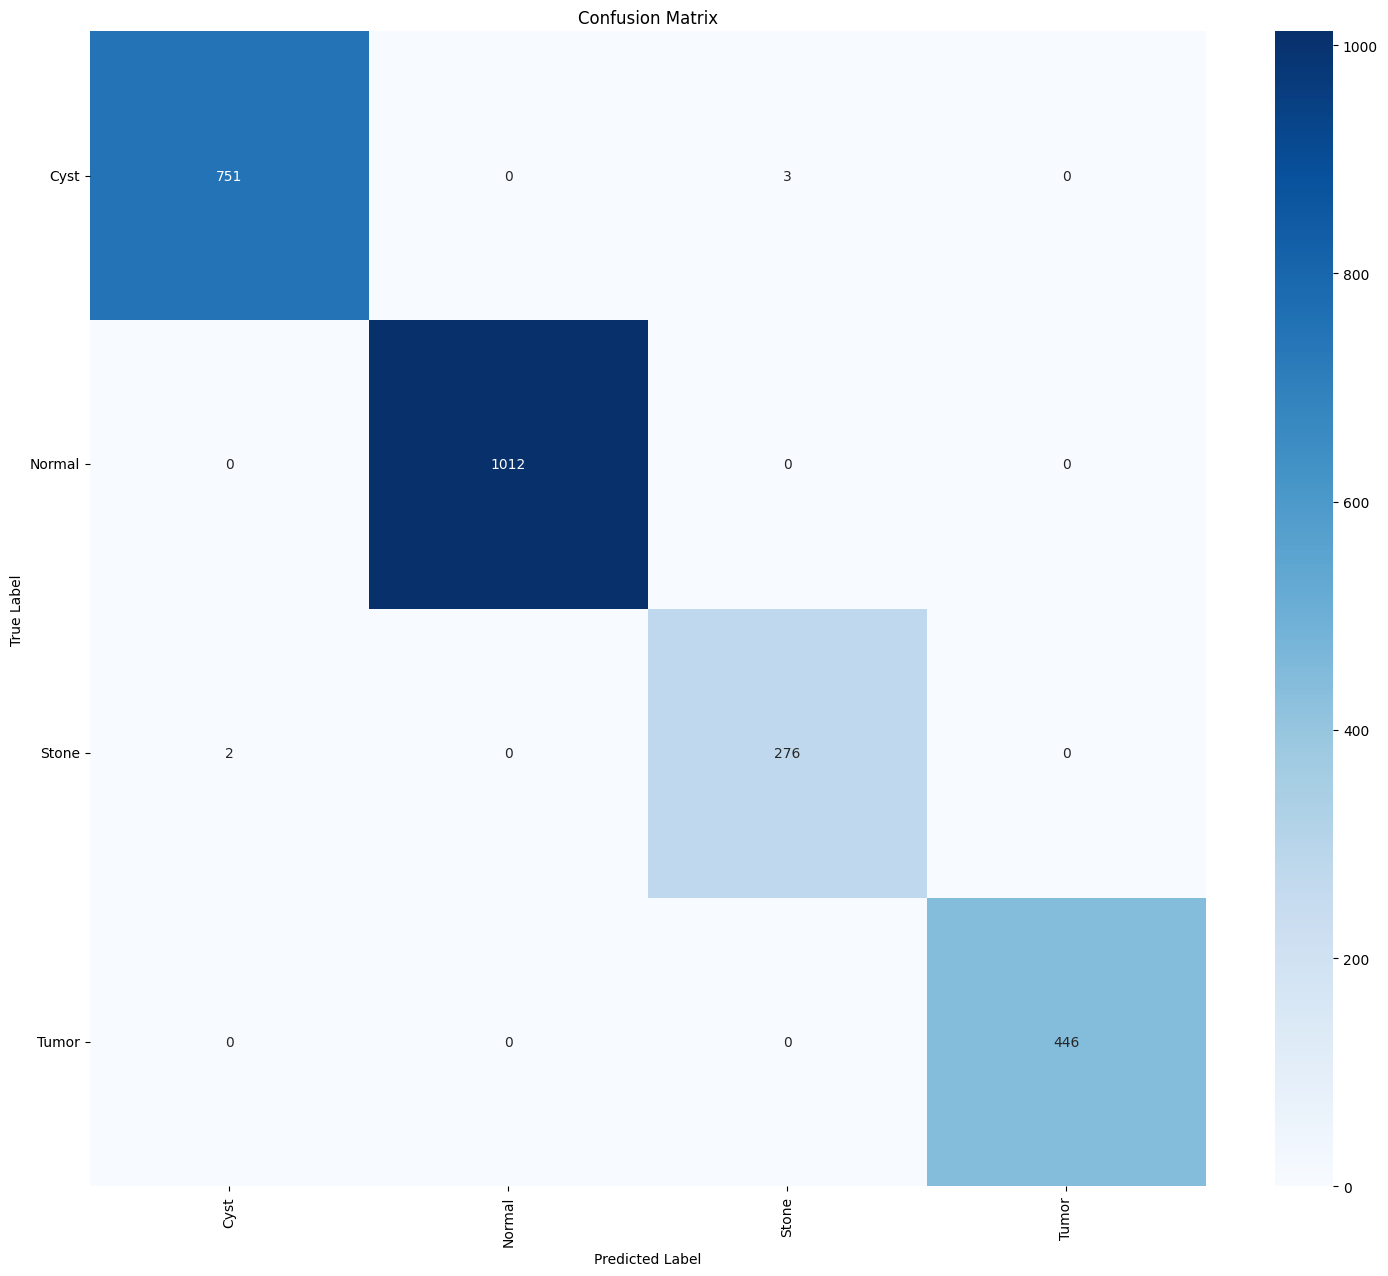

In [70]:
from sklearn.metrics import confusion_matrix
class_names =sorted(df.iloc[:, 4].unique())
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12 * 1.5, 10 * 1.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90) 
plt.yticks(rotation=0)
plt.show()


In [72]:

class kidneyEfficientNet(nn.Module):
    def __init__(self, num_classes=44):
        super(kidneyEfficientNet, self).__init__()
        
        self.base_model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1)
        self.base_model.classifier = nn.Identity() 
        
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 256, bias=True),
            nn.ReLU(),
            nn.Dropout(0.45),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1) 
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = kidneyEfficientNet(num_classes=44).to(device)

model.load_state_dict(torch.load("/kaggle/working/brain_tumor_model.pth_epoch8.pth", map_location=device))
model.eval() 


def predict_image(image_path, model, class_names, device):
    transform = transforms.Compose([
    transforms.Resize((128, 128)),   
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(15),  
    transforms.ToTensor(),
])

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device) 

    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)

    return class_names[predicted_class.item()]  


<ipython-input-72-3795ed1e3243>:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/brain_tumor_model.pth_epoch8.pth", map_lo

In [73]:
model.eval()
image_path = "/kaggle/input/ct-kidney-dataset-normal-cyst-tumor-and-stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst/Cyst- (10).jpg" 
predicted_label = predict_image(image_path, model, class_names, device)
print(f"Predicted Class: {predicted_label}")

Predicted Class: Cyst
